generate multi strategy backtest using same strategy with a set of different model parameters and generate factsheet report

In [1]:
# packages
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, List
from enum import Enum
import yfinance as yf
import qis
from qis import TimePeriod, MultiPortfolioData, generate_multi_portfolio_factsheet, fetch_default_report_kwargs

In [3]:
def fetch_universe_data() -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series]:
    """
    define custom universe with asset class grouping
    """
    universe_data = dict(SPY='Equities',
                         QQQ='Equities',
                         EEM='Equities',
                         TLT='Bonds',
                         IEF='Bonds',
                         LQD='Credit',
                         HYG='HighYield',
                         GLD='Gold')
    tickers = list(universe_data.keys())
    group_data = pd.Series(universe_data)  # for portfolio reporting
    prices = yf.download(tickers=tickers, start=None, end=None, ignore_tz=True)['Adj Close'][tickers]
    prices = prices.asfreq('B', method='ffill')
    benchmark_prices = prices[['SPY', 'TLT']]
    return prices, benchmark_prices, group_data

In [4]:
# define strategy
def generate_volparity_multi_strategy(prices: pd.DataFrame,
                                      benchmark_prices: pd.DataFrame,
                                      group_data: pd.Series,
                                      time_period: TimePeriod,
                                      spans: List[int] = (5, 10, 20, 40, 60, 120),
                                      vol_target: float = 0.15,
                                      rebalancing_costs: float = 0.0010
                                      ) -> MultiPortfolioData:
    """
    generate volparity sensitivity to span
    """
    returns = qis.to_returns(prices=prices, is_log_returns=True)

    portfolio_datas = []
    for span in spans:
        ra_returns, weights, ewm_vol = qis.compute_ra_returns(returns=returns, span=span, vol_target=vol_target)
        weights = weights.divide(weights.sum(1), axis=0)
        portfolio_data = qis.backtest_model_portfolio(prices=prices,
                                                      weights=time_period.locate(weights),
                                                      rebalancing_costs=rebalancing_costs,
                                                      ticker=f"VP span={span}")
        portfolio_data.set_group_data(group_data=group_data, group_order=list(group_data.unique()))
        portfolio_datas.append(portfolio_data)

    multi_portfolio_data = MultiPortfolioData(portfolio_datas, benchmark_prices=benchmark_prices)
    return multi_portfolio_data

In [7]:
# fetch universe prices
prices, benchmark_prices, group_data = fetch_universe_data()

[*********************100%%**********************]  8 of 8 completed


In [5]:
# time period for portfolio reporting
time_period = qis.TimePeriod('31Dec2005', '16Oct2024')  

In [9]:
# run multistrategy
multi_portfolio_data = generate_volparity_multi_strategy(prices=prices,
                                                                 benchmark_prices=benchmark_prices,
                                                                 group_data=group_data,
                                                                 time_period=time_period,
                                                                 vol_target=0.15,
                                                                 rebalancing_costs=0.0010  # per traded volume
                                                                 )

[*********************100%%**********************]  1 of 1 completed


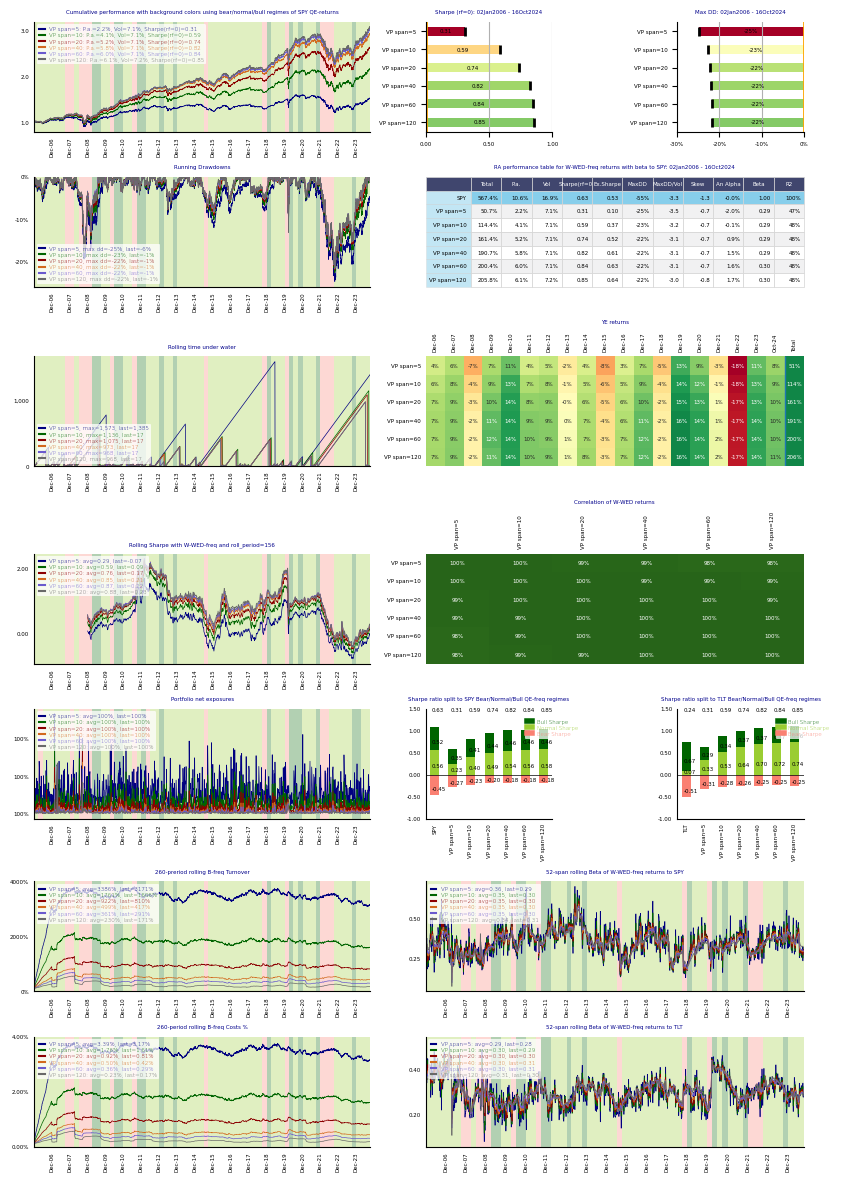

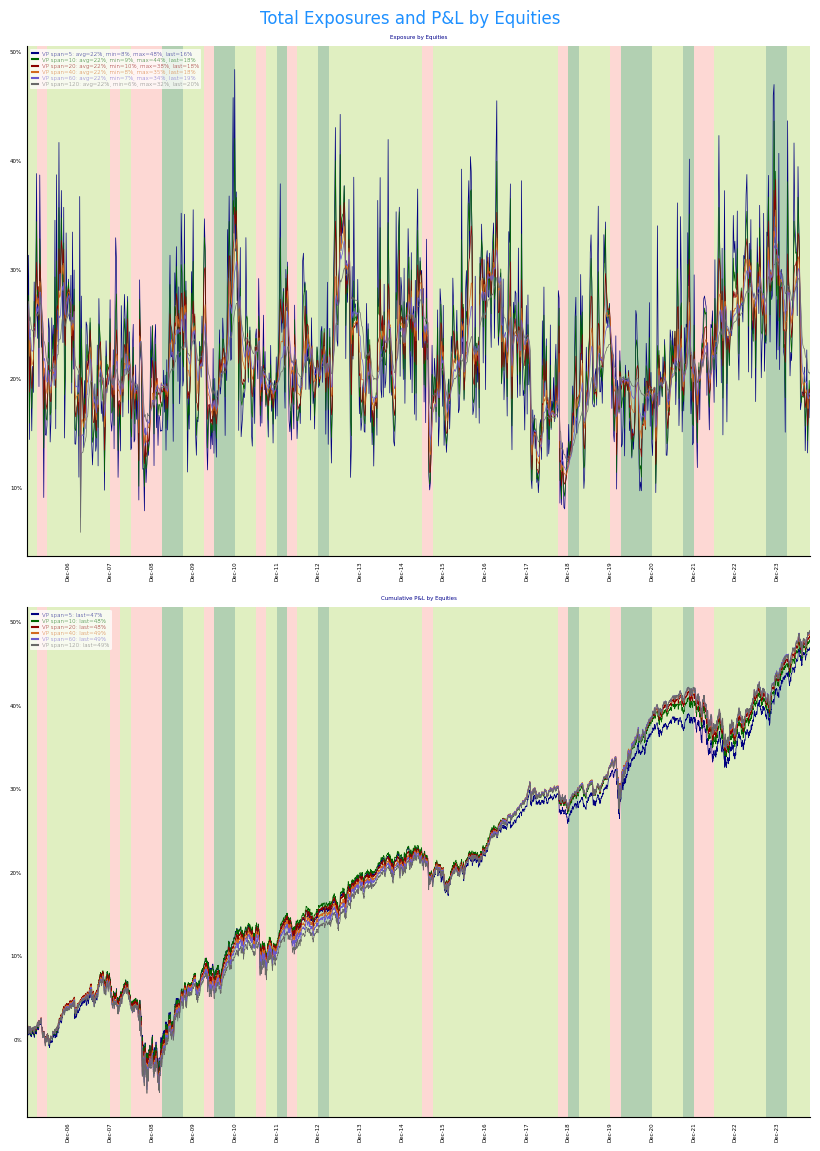

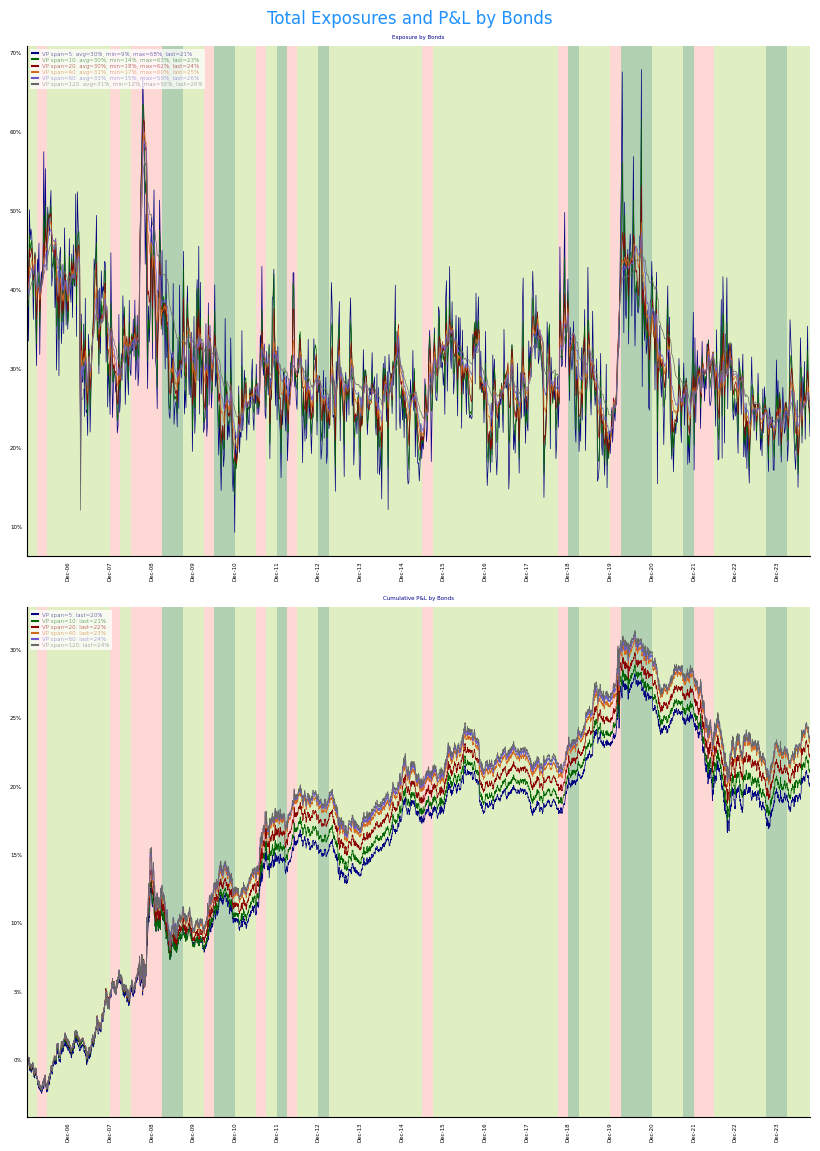

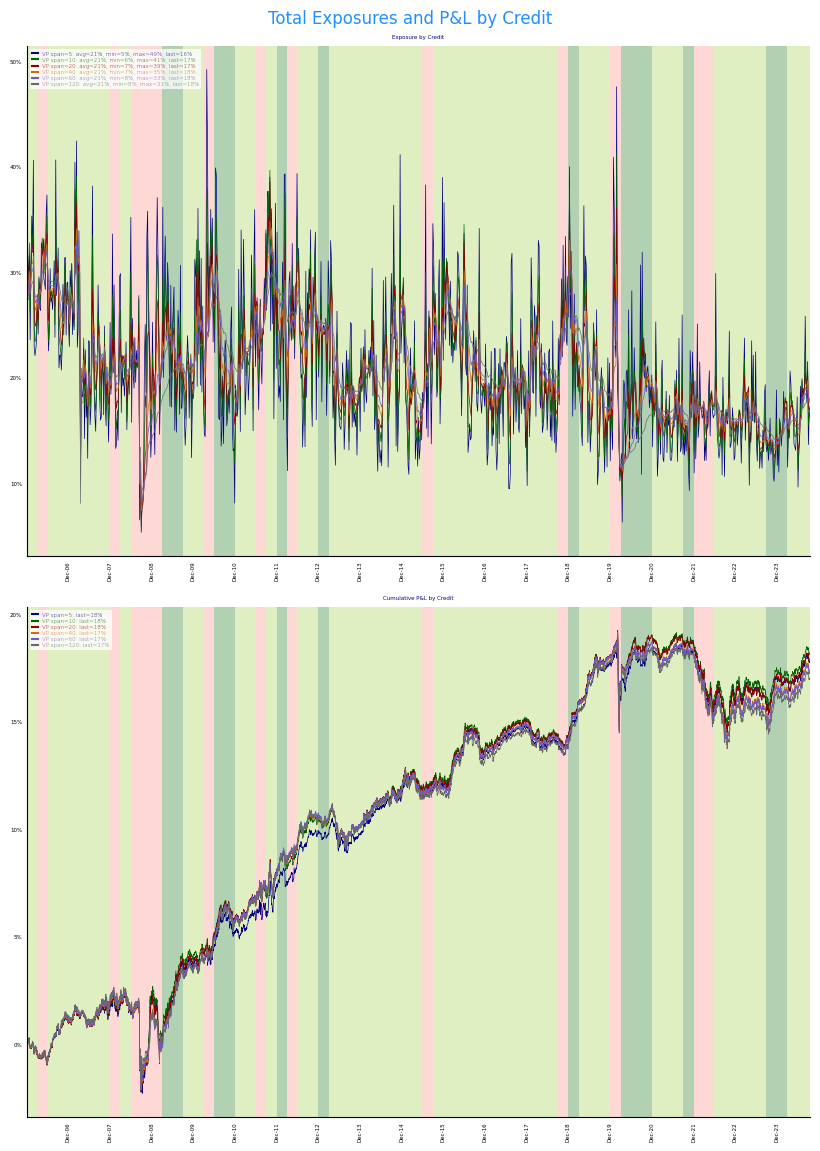

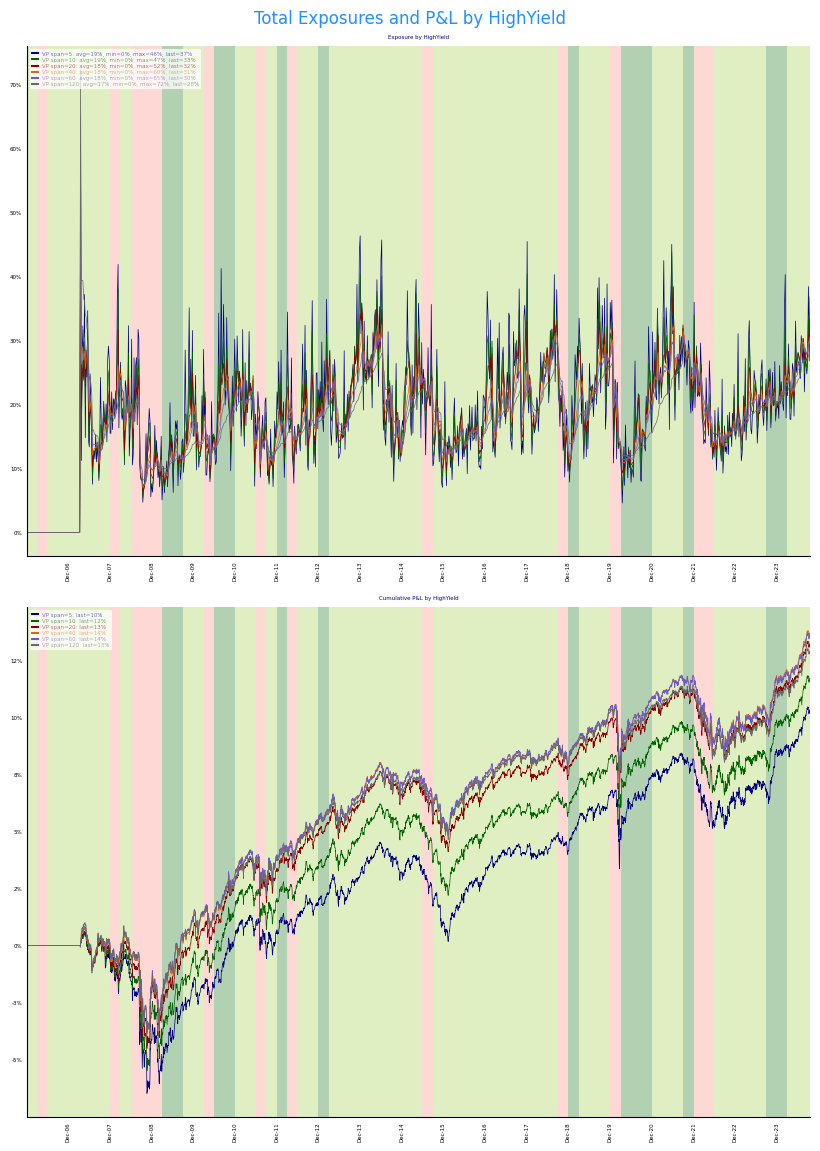

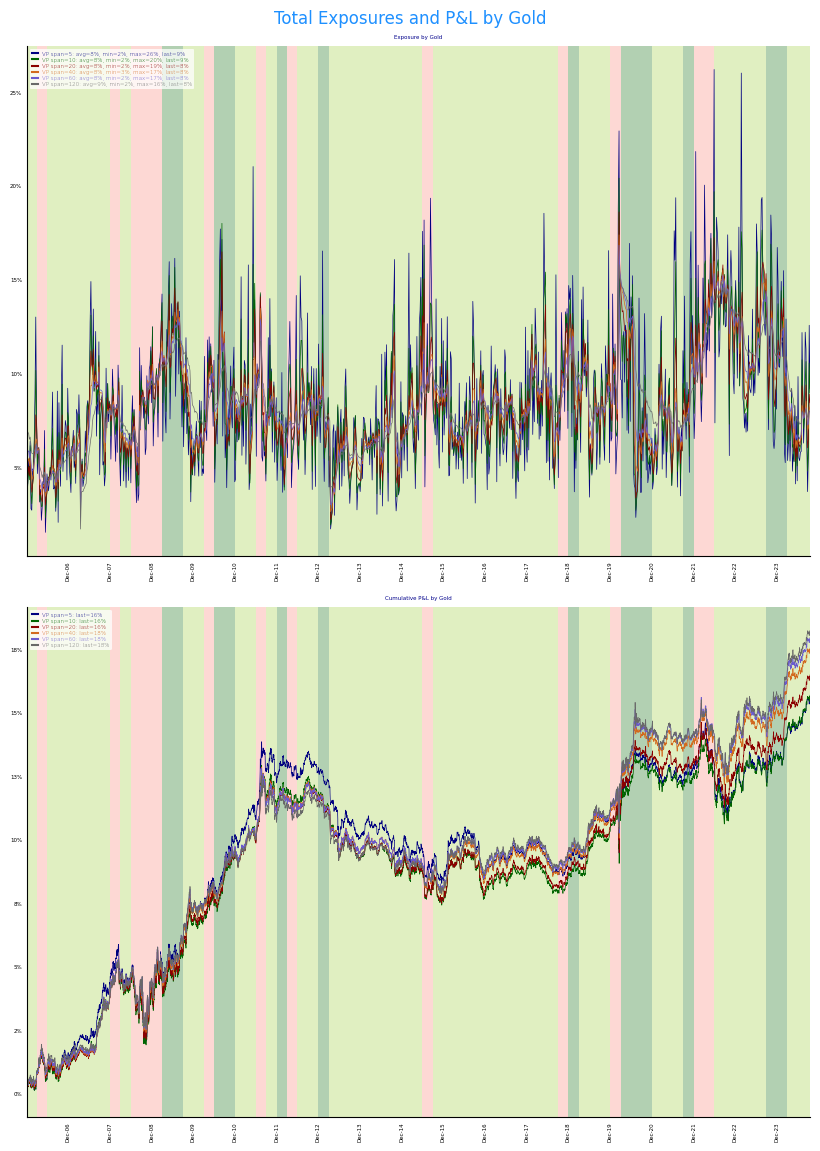

In [10]:
# generate factsheet
figs = generate_multi_portfolio_factsheet(multi_portfolio_data=multi_portfolio_data,
                                          time_period=time_period,
                                                  add_group_exposures_and_pnl=True,
                                                  **fetch_default_report_kwargs(time_period=time_period))